In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gdown
import clip
import torch
import torch.nn as nn
from torchvision import transforms
from IPython.display import display

# Used for visualization purposes
size_ = 512 
resize = transforms.Resize(size_)
center_crop = transforms.CenterCrop(size_)

### Load Data

In [2]:
# Download the dataset (flickrUser.csv) from the following link (skip if you already have the dataset):
file_id = '1Q2IJi_xn2cbUTcmtJ26rLPvKcjWT1bsb'
url = f'https://drive.google.com/uc?id={file_id}'
# The file will be saved as 'flickrUser.csv'
output = 'flickrUser.csv'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Q2IJi_xn2cbUTcmtJ26rLPvKcjWT1bsb
From (redirected): https://drive.google.com/uc?id=1Q2IJi_xn2cbUTcmtJ26rLPvKcjWT1bsb&confirm=t&uuid=fc1073f8-54bd-475b-8fa6-070812bbbabb
To: /home/abdu/ECCV2024_Commonly-Interesting-Images/flickrUser.csv
100%|██████████| 278M/278M [00:03<00:00, 74.9MB/s] 


'flickrUser.csv'

In [3]:
# Load the dataset
df = pd.read_csv('flickrUser.csv')
df_train = df[df['set'] == 'train']
df_test = df[df['set'] == 'test']

In [4]:
df.head()

,user,img_id,img_url,views,favorites,comments,upload_date,user_gender,user_timezone_label,user_timezone_id,...,rule of thirds,shallow dof,silhouette,soft focus,vanishing point,main_feature,quality_score,emotion_score,emotion,emotion_category
0,99856385@N00,871879294,https://farm2.staticflickr.com/1095/871879294_...,1401,1,0,2007-07-22,M,Pacific Time (US & Canada); Tijuana,PST8PDT,...,0.132317,0.129257,0.096200,0.129303,0.146249,vanishing point,0.377751,0.527344,This image makes me happy,Contentment
1,99856385@N00,844661345,https://farm2.staticflickr.com/1086/844661345_...,908,2,3,2007-07-18,M,Pacific Time (US & Canada); Tijuana,PST8PDT,...,0.143546,0.127069,0.099577,0.116660,0.126529,rule of thirds,0.313734,0.269043,This image makes me angry,Anger
2,99856385@N00,73377743,https://farm1.staticflickr.com/20/73377743_a04...,1016,2,0,2005-12-14,M,Pacific Time (US & Canada); Tijuana,PST8PDT,...,0.141628,0.131062,0.120148,0.118825,0.131690,complementary colors,0.423448,0.190308,This image is thrilling,Excitement
3,99856385@N00,6746902917,https://farm8.staticflickr.com/7172/6746902917...,137,1,0,2012-01-23,M,Pacific Time (US & Canada); Tijuana,PST8PDT,...,0.129272,0.109076,0.110654,0.135553,0.128972,light on white,0.494865,0.361572,This image gives me a feeling of disgust,Disgust
4,99856385@N00,616837596,https://farm2.staticflickr.com/1075/616837596_...,235,2,0,2007-06-25,M,Pacific Time (US & Canada); Tijuana,PST8PDT,...,0.145324,0.115524,0.113497,0.120785,0.122457,long exposure,0.707541,0.507324,This image is thrilling,Excitement


### Data-driven Definition of Common Interest

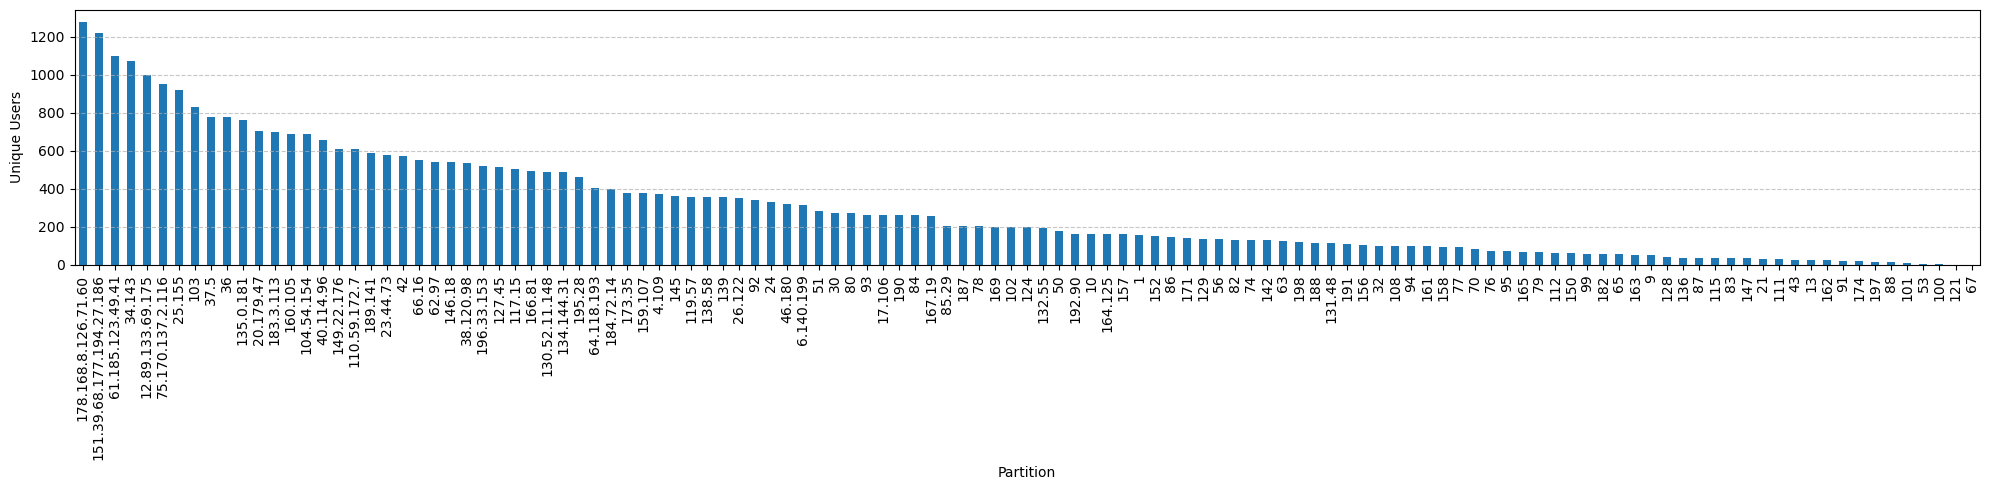

In [5]:
# Common Interestingness (cf. Figure 2)
unique_users = df_train.groupby(['partition'])['user'].nunique().reset_index(name='unique_users')
unique_users.sort_values(by='unique_users', ascending=False, inplace=True)
unique_users.reset_index(drop=True, inplace=True)

# Bar plot of unique users per cluster
unique_users['unique_users'].plot(kind='bar', figsize=(20, 5))
plt.xlabel('Partition')
plt.ylabel('Unique Users')
plt.xticks(ticks=np.arange(0, len(unique_users), 1), labels=unique_users['partition'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### What Makes an Image Commonly Interesting?

In [6]:
df_train_common = df_train[(df_train['group'] == 0)]
df_train_interplay = df_train[(df_train['group'] == 1)]
df_train_subjective = df_train[(df_train['group'] == 2)]

In [7]:
# Perceptual Features (cf. Table 1)
perceptual_features_common = df_train_common.value_counts(subset = ['main_feature'], normalize=True).round(4) * 100
aesthetic_score_common = df_train_common['quality_score'].describe()[['25%', '50%', '75%']].round(4) * 100

perceptual_features_interplay = df_train_interplay.value_counts(subset = ['main_feature'], normalize=True).round(4) * 100
aesthetic_score_interplay = df_train_interplay['quality_score'].describe()[['25%', '50%', '75%']].round(4) * 100

perceptual_features_subjective = df_train_subjective.value_counts(subset = ['main_feature'], normalize=True).round(4) * 100
aesthetic_score_subjective = df_train_subjective['quality_score'].describe()[['25%', '50%', '75%']].round(4) * 100

df_perceptual_features = pd.concat([perceptual_features_common, perceptual_features_interplay, perceptual_features_subjective], axis=1)
df_perceptual_features.columns = ['Common', 'Interplay', 'Subjective']
df_perceptual_features['Delta'] = df_perceptual_features['Common'] - df_perceptual_features['Subjective']
df_perceptual_features.sort_values(by='Delta', ascending=False, inplace=True)
df_perceptual_features.index.names = ['Scores from VILA']
display(df_perceptual_features)

df_aesthetic_score = pd.concat([aesthetic_score_common, aesthetic_score_interplay, aesthetic_score_subjective], axis=1)
df_aesthetic_score.columns = ['Common', 'Interplay', 'Subjective']
df_aesthetic_score['Delta'] = df_aesthetic_score['Common'] - df_aesthetic_score['Subjective']
df_aesthetic_score.index.names = ['Scores from VILA']
display(df_aesthetic_score)

,Common,Interplay,Subjective,Delta
Scores from VILA,,,,
hdr,20.68,15.81,15.22,5.46
shallow dof,8.39,4.51,3.10,5.29
vanishing point,8.88,9.59,4.39,4.49
long exposure,6.68,1.52,2.42,4.26
silhouette,3.51,1.33,0.87,2.64
macro,3.76,1.65,2.06,1.70
soft focus,10.03,7.92,9.41,0.62
image grain,1.48,0.97,1.73,-0.25
rule of thirds,14.82,23.92,15.43,-0.61


,Common,Interplay,Subjective,Delta
Scores from VILA,,,,
25%,47.03,39.30,38.14,8.89
50%,55.49,47.78,46.72,8.77
75%,63.66,56.14,55.34,8.32


In [8]:
# Connotative Features (cf. Table 3)
connotative_features_common = df_train_common.value_counts(subset = ['emotion_category'], normalize=True).round(4) * 100
connotative_features_interplay = df_train_interplay.value_counts(subset = ['emotion_category'], normalize=True).round(4) * 100
connotative_features_subjective = df_train_subjective.value_counts(subset = ['emotion_category'], normalize=True).round(4) * 100

connotative_features_positive = ['Excitement', 'Awe', 'Contentment', 'Amusement']
connotative_features_negative = ['Sadness', 'Disgust', 'Anger', 'Fear']

df_connotative_features_positive = pd.concat([connotative_features_common[connotative_features_positive], connotative_features_interplay[connotative_features_positive], connotative_features_subjective[connotative_features_positive]], axis=1)
df_connotative_features_positive.columns = ['Common', 'Interplay', 'Subjective']
df_connotative_features_positive.index = ['Excitement', 'Awe', 'Contentment', 'Amusement']
df_connotative_features_positive['Delta'] = df_connotative_features_positive['Common'] - df_connotative_features_positive['Subjective']
df_connotative_features_positive.sort_values(by='Delta', ascending=False, inplace=True)
df_connotative_features_positive.loc['Sum Positive'] = df_connotative_features_positive.sum()
df_connotative_features_positive.index.names = ['Scores from CLIP']
display(df_connotative_features_positive)

df_connotative_features_negative = pd.concat([connotative_features_common[connotative_features_negative], connotative_features_interplay[connotative_features_negative], connotative_features_subjective[connotative_features_negative]], axis=1)
df_connotative_features_negative.columns = ['Common', 'Interplay', 'Subjective']
df_connotative_features_negative.index = ['Sadness', 'Disgust', 'Anger', 'Fear']
df_connotative_features_negative['Delta'] = df_connotative_features_negative['Common'] - df_connotative_features_negative['Subjective']
df_connotative_features_negative.sort_values(by='Delta', ascending=False, inplace=True)
df_connotative_features_negative.loc['Sum Negative'] = df_connotative_features_negative.sum()
df_connotative_features_negative.index.names = ['Scores from CLIP']
display(df_connotative_features_negative)

,Common,Interplay,Subjective,Delta
Scores from CLIP,,,,
Excitement,60.80,35.56,32.13,28.67
Awe,18.07,15.82,9.40,8.67
Contentment,4.79,10.77,9.43,-4.64
Amusement,5.59,16.02,17.56,-11.97
Sum Positive,89.25,78.17,68.52,20.73


,Common,Interplay,Subjective,Delta
Scores from CLIP,,,,
Fear,0.65,2.83,2.10,-1.45
Disgust,0.91,3.81,6.60,-5.69
Sadness,8.25,12.32,14.63,-6.38
Anger,0.95,2.85,8.15,-7.20
Sum Negative,10.76,21.81,31.48,-20.72


### Computational Model

In [9]:
# Load CLIP the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device=device)

# Load the CI_R model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(768, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Load the model
model_ci_r = RegressionModel().to(device)
model_ci_r.load_state_dict(torch.load('CI_R_model.pth'))
model_ci_r.eval()

RegressionModel(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
  )
)

In [10]:
img_path_libertyStatue = [os.path.join('./sampleImages/libertyStatue/', img_path) for img_path in os.listdir('./sampleImages/libertyStatue/')]
img_path_eiffelTower = [os.path.join('./sampleImages/eiffelTower/', img_path) for img_path in os.listdir('./sampleImages/eiffelTower/')]

In [11]:
# Extract features from the images
image_features_libertyStatue = []
image_features_eiffelTower = []
for i in range(len(img_path_libertyStatue)):
    image_libertyStatue = preprocess(Image.open(img_path_libertyStatue[i])).unsqueeze(0).to('cuda')
    image_eiffelTower = preprocess(Image.open(img_path_eiffelTower[i])).unsqueeze(0).to('cuda')
    with torch.no_grad():
        image_features_libertyStatue.append(model.encode_image(image_libertyStatue))
        image_features_eiffelTower.append(model.encode_image(image_eiffelTower))

image_features_libertyStatue = [image_feature.cpu().detach().numpy() for image_feature in image_features_libertyStatue]
image_features_libertyStatue = np.array(image_features_libertyStatue).reshape(len(image_features_libertyStatue), -1)

image_features_eiffelTower = [image_feature.cpu().detach().numpy() for image_feature in image_features_eiffelTower]
image_features_eiffelTower = np.array(image_features_eiffelTower).reshape(len(image_features_eiffelTower), -1)

# Print the shape of the extracted features
print(f'Image features (Liberty Statue): {image_features_libertyStatue.shape}')
print(f'Image features (Eiffel Tower): {image_features_eiffelTower.shape}')

Image features (Liberty Statue): (9, 768)
Image features (Eiffel Tower): (9, 768)


In [12]:
# Predict the CI score
ci_score_libertyStatue = model_ci_r(torch.tensor(image_features_libertyStatue, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
ci_score_eiffelTower = model_ci_r(torch.tensor(image_features_eiffelTower, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

# Create a dataframe with the image paths and their CI scores
df_ci_score_libertyStatue = pd.DataFrame({'img_path': img_path_libertyStatue, 'ci_score': ci_score_libertyStatue})
df_ci_score_libertyStatue.sort_values(by='ci_score', ascending=False, inplace=True)
df_ci_score_eiffelTower = pd.DataFrame({'img_path': img_path_eiffelTower, 'ci_score': ci_score_eiffelTower})
df_ci_score_eiffelTower.sort_values(by='ci_score', ascending=False, inplace=True)

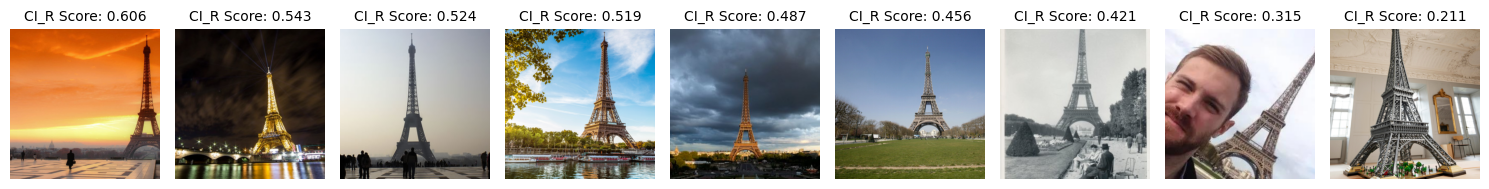

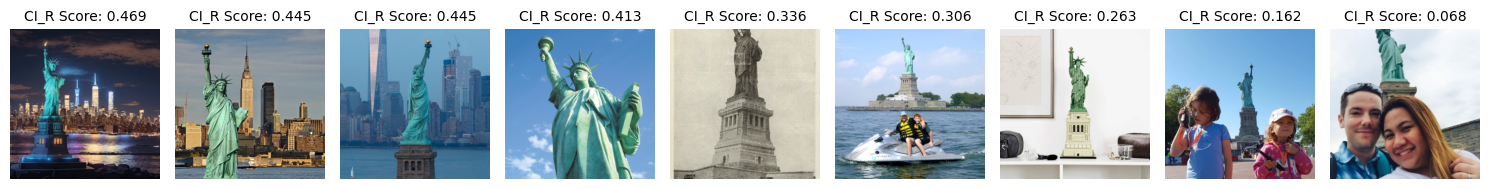

In [15]:
# Display the images with their CI scores (cf. Figure 6)
fig, ax = plt.subplots(1, df_ci_score_eiffelTower.shape[0], figsize=(15, 5))
for i in range(df_ci_score_eiffelTower.shape[0]):
    img = Image.open(df_ci_score_eiffelTower['img_path'].iloc[i])
    ax[i].imshow(center_crop(resize(img)))
    ax[i].axis('off')
    ax[i].set_title(f'CI_R Score: {df_ci_score_eiffelTower["ci_score"].iloc[i]:.3f}', fontsize=10)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, df_ci_score_libertyStatue.shape[0], figsize=(15, 5))
for i in range(df_ci_score_libertyStatue.shape[0]):
    img = Image.open(df_ci_score_libertyStatue['img_path'].iloc[i])
    ax[i].imshow(center_crop(resize(img)))
    ax[i].axis('off')
    ax[i].set_title(f'CI_R Score: {df_ci_score_libertyStatue["ci_score"].iloc[i]:.3f}', fontsize=10)
plt.tight_layout()
plt.show()